In [2]:
pip install librosa

   ---------------------------------------- 0.0/260.7 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/260.7 kB 1.3 MB/s eta 0:00:01
   ----------------- ---------------------- 112.6/260.7 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------  256.0/260.7 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 260.7/260.7 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/74.7 kB ? eta -:--:--
   ---------------------------------------- 74.7/74.7 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.8 MB 6.8 MB/s eta 0:00:01
   -- ------------------------------------- 0.2/2.8 MB 3.1 MB/s eta 0:00:01
   --- ------------------------------------ 0.3/2.8 MB 2.4 MB/s eta 0:00:02
   ----- ---------------------------------- 0.4/2.8 MB 2.2 MB/s eta 0:00:02
   ------ --------------------------------- 0.5/2.8 MB 2.3 MB/s eta 0:00:02
   ------- --

In [27]:
import os
import wave
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, filtfilt, lfilter
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
def load_audio_from_folder(folder_path, label):
    audio_data = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'): 
            full_path = os.path.join(folder_path, filename)
            try:
                signal, sr = librosa.load(full_path, sr=None)  # sr=None untuk mempertahankan frekuensi asli
                duration = len(signal) / sr
                audio_data.append({
                    'filename': full_path,
                    'signal': signal,
                    'sampling_rate': sr,
                    'duration': duration,
                    'label': label  # Menambahkan label untuk setiap kategori
                })
            except Exception as e:
                print(f"Error reading {full_path}: {e}")

    return audio_data

artifact_path = 'Heartbeat_Sound/artifact'
artifact_audio = load_audio_from_folder(artifact_path, 'artifact')
df_artifact = pd.DataFrame(artifact_audio)

extrahls_path = 'Heartbeat_Sound/extrahls'
extrahls_audio = load_audio_from_folder(extrahls_path, 'extrahls')
df_extrahls = pd.DataFrame(extrahls_audio)

extrastole_path = 'Heartbeat_Sound/extrastole'
extrastole_audio = load_audio_from_folder(extrastole_path, 'extrastole')
df_extrastole = pd.DataFrame(extrastole_audio)

murmur_path = 'Heartbeat_Sound/murmur'
murmur_audio = load_audio_from_folder(murmur_path, 'murmur')
df_murmur = pd.DataFrame(murmur_audio)

normal_path = 'Heartbeat_Sound/normal'
normal_audio = load_audio_from_folder(normal_path, 'normal')
df_normal = pd.DataFrame(normal_audio)

df = pd.concat([df_artifact,df_murmur, df_normal, df_extrastole, df_extrahls], ignore_index=True)

In [6]:
df['label'].value_counts()

label
normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: count, dtype: int64

## Preprocessing

In [7]:
df

,filename,signal,sampling_rate,duration,label
0,Heartbeat_Sound/artifact\artifact__20101217201...,"[3.0517578e-05, -9.1552734e-05, -3.0517578e-05...",44100,9.000000,artifact
1,Heartbeat_Sound/artifact\artifact__20110504091...,"[-6.1035156e-05, 9.1552734e-05, -0.00012207031...",44100,9.000000,artifact
2,Heartbeat_Sound/artifact\artifact__20110504195...,"[0.00018310547, -0.00012207031, -0.0002746582,...",44100,9.000000,artifact
3,Heartbeat_Sound/artifact\artifact__20110505101...,"[-0.0025939941, -0.0060424805, -0.0065307617, ...",44100,9.000000,artifact
4,Heartbeat_Sound/artifact\artifact__20110506010...,"[0.0016174316, -0.0010681152, 0.0014343262, 0....",44100,9.000000,artifact
...,...,...,...,...,...
580,Heartbeat_Sound/extrahls\extrahls__20110320021...,"[0.010040283, 0.009857178, 0.010345459, 0.0101...",44100,9.000000,extrahls
581,Heartbeat_Sound/extrahls\extrahls__20110402135...,"[-0.00079345703, -0.00088500977, -0.0010681152...",44100,0.936372,extrahls
582,Heartbeat_Sound/extrahls\extrahls__20110414011...,"[0.00030517578, -3.0517578e-05, -0.00012207031...",44100,1.947392,extrahls
583,Heartbeat_Sound/extrahls\extrahls__20110427045...,"[-0.03036499, -0.028900146, -0.028198242, -0.0...",44100,3.235397,extrahls


In [9]:
def normalize_audio(signal):
    """Normalizes the audio signal to the range [-1, 1]."""
    return signal / np.max(np.abs(signal))

def band_pass_filter(signal, lowcut, highcut, fs, order=5):
    """Applies a band-pass filter to the audio signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

def clip_or_pad(signal, target_samples):
    """Clips or pads the audio signal to the target length."""
    if len(signal) < target_samples:
        signal = np.pad(signal, (0, target_samples - len(signal)), 'constant')
    else:
        signal = signal[:target_samples]
    return signal  # Return the processed signal

def preprocess(row, target_duration):
    """Processes a single row of the DataFrame."""
    signal = row['signal']
    sr = row['sampling_rate']
    target_samples = int(target_duration * sr)
    
    normalized_signal = normalize_audio(signal)
    
    processed_signal = clip_or_pad(normalized_signal, target_samples)
    
    # Adjust the band-pass filter frequencies according to the characteristics of your data
    filtered_signal = band_pass_filter(processed_signal, lowcut=100, highcut=1500, fs=sr)
    
    return filtered_signal

# Define target duration for padding/clipping
target_duration = 6  # in seconds
df['processed_signal'] = df.apply(lambda row: preprocess(row, target_duration), axis=1)

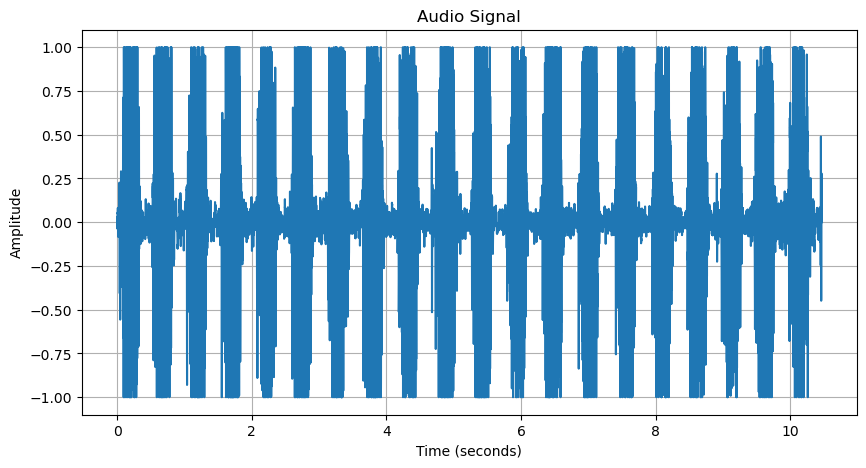

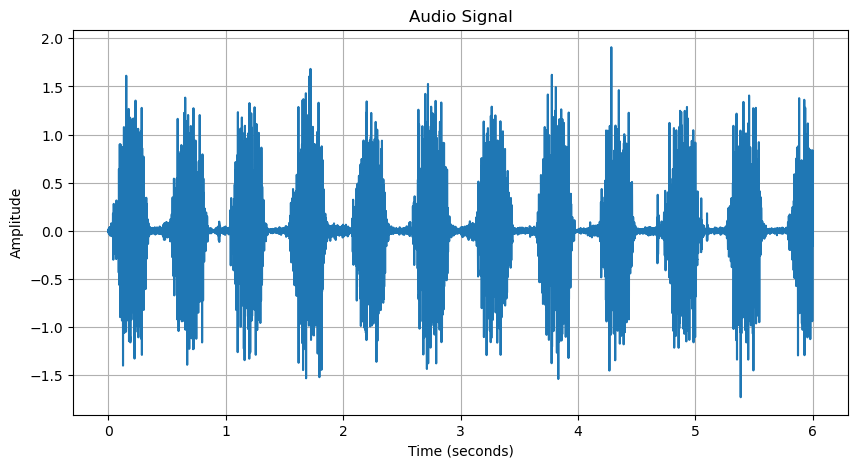

In [11]:
def plot_signal(signal, fs):
    """Plot the audio signal."""
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(10, 5))
    plt.plot(time, signal)
    plt.title('Audio Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

fs = 4000  # Sampling rate
plot_signal(df['signal'][100], fs)
plot_signal(df['processed_signal'][100], fs)

### Feature Extraction

In [12]:
def extract_features(signal, sr):
    # Menghitung rata-rata interval detak
    intervals = np.diff(np.where(signal > 0)[0]) / sr
    mean_interval = np.mean(intervals) if len(intervals) > 0 else np.nan

    # Menghitung HRV (SDNN dan RMSSD)
    sdnn = np.std(intervals) if len(intervals) > 0 else np.nan
    rmssd = np.sqrt(np.mean(np.square(np.diff(intervals)))) if len(intervals) > 1 else np.nan

    # Menghitung FFT dan puncak frekuensi
    freqs = np.fft.rfftfreq(len(signal), d=1/sr)
    fft_values = np.abs(np.fft.rfft(signal))
    peak_freq = freqs[np.argmax(fft_values)] if len(fft_values) > 0 else np.nan

    # Menghitung energi
    energy = np.sum(signal**2)

    # Menghitung MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)

    # Zero-crossing rate
    zero_crossings = librosa.feature.zero_crossing_rate(signal)[0]
    zero_crossing_rate = np.mean(zero_crossings)

    # Spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]
    spectral_centroid_mean = np.mean(spectral_centroid)

    # Spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)[0]
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # RMS Energy
    rms = librosa.feature.rms(y=signal)[0]
    rms_mean = np.mean(rms)

    return {
        'mean_interval': mean_interval,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'peak_freq': peak_freq,
        'energy': energy,
        'mfcc_mean': mfcc_mean,
        'zero_crossing_rate': zero_crossing_rate,
        'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_bandwidth_mean': spectral_bandwidth_mean,
        'chroma_mean': chroma_mean,
        'rms_mean': rms_mean
    }


def process_feature_extract(df):
    all_features = []

    for index, row in df.iterrows():
        signal = row['processed_signal']
        sr = row['sampling_rate']
        
        features = extract_features(signal, sr)
        features['filename'] = row['filename']
        
        all_features.append(features)

    return pd.DataFrame(all_features)

features_df = process_feature_extract(df)

features_df.head()

,mean_interval,sdnn,rmssd,peak_freq,energy,mfcc_mean,zero_crossing_rate,spectral_centroid_mean,spectral_bandwidth_mean,chroma_mean,rms_mean,filename
0,0.000045,0.000170,0.000243,181.666667,145.288924,"[-576.5830033241881, 42.4807548287202, 22.0072...",0.030981,785.068608,555.881113,"[0.57921060788811, 0.5494573176662759, 0.56173...",0.004324,Heartbeat_Sound/artifact\artifact__20101217201...
1,0.000045,0.000129,0.000185,211.166667,148.151620,"[-591.0930282083615, 72.61962264099854, 10.406...",0.041962,958.109446,622.322985,"[0.5942578927973968, 0.6090658466992702, 0.616...",0.009696,Heartbeat_Sound/artifact\artifact__20110504091...
2,0.000046,0.000132,0.000189,463.666667,177.689774,"[-472.5488412621986, 233.50278592498535, 23.65...",0.039681,922.469841,553.807820,"[0.58985941156076, 0.6718455575767825, 0.60735...",0.016369,Heartbeat_Sound/artifact\artifact__20110504195...
3,0.000045,0.000172,0.000246,467.500000,73.003435,"[-496.0363088234935, 222.8071052952423, 57.081...",0.022709,655.737940,464.209141,"[0.48849284425059963, 0.45427845884236695, 0.4...",0.013869,Heartbeat_Sound/artifact\artifact__20110505101...
4,0.000045,0.000167,0.000238,173.666667,471.737747,"[-422.2670699562918, 165.601640650228, 51.4227...",0.027088,718.736199,507.577118,"[0.5678437042125806, 0.6021268103545843, 0.573...",0.020556,Heartbeat_Sound/artifact\artifact__20110506010...


### Modelling

In [13]:
mfcc_flattened = np.array(features_df['mfcc_mean'].tolist())
chroma_flattened = np.array(features_df['chroma_mean'].tolist())

X = np.hstack((
    features_df[['mean_interval', 'sdnn', 'rmssd', 'peak_freq', 'energy','zero_crossing_rate', 'spectral_centroid_mean',
       'spectral_bandwidth_mean','rms_mean']].values,
    mfcc_flattened,chroma_flattened
))

In [15]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint,TensorBoard,ProgbarLogger
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(df['label'])

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42, stratify=y_train)

y_train = np.array(tf.keras.utils.to_categorical(y_train, 5))
y_test = np.array(tf.keras.utils.to_categorical(y_test, 5))
y_val = np.array(tf.keras.utils.to_categorical(y_val, 5))

In [16]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)*10

class_weights_dict = {i: class_weights[i] for i in range(len(classes))}

print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: 29.25, 1: 61.578947368421055, 2: 25.434782608695656, 3: 9.069767441860465, 4: 3.333333333333333}


In [17]:
x_train

array([[5.00897779e-04, 9.69384910e-04, 1.40724967e-03, ...,
        4.67387520e-01, 3.42947927e-01, 2.96769017e-01],
       [5.04691181e-04, 7.78384185e-04, 1.14716024e-03, ...,
        6.69509077e-01, 6.81238269e-01, 6.56645940e-01],
       [5.00981293e-04, 9.75182739e-04, 1.41791464e-03, ...,
        7.07728099e-01, 4.72132137e-01, 3.67788957e-01],
       ...,
       [5.01987448e-04, 9.30504218e-04, 1.35110215e-03, ...,
        6.58463070e-01, 5.08253426e-01, 4.46123197e-01],
       [4.60771282e-05, 3.02649222e-04, 4.29289842e-04, ...,
        6.11899299e-01, 6.11101399e-01, 6.29493240e-01],
       [4.56050122e-05, 2.14111563e-04, 3.04420913e-04, ...,
        6.55558222e-01, 6.62197267e-01, 6.92127160e-01]])

### Train

In [18]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    
    # LSTM layer with tunable units and dropout
    model.add(Bidirectional(LSTM(
        units=hp.Choice('units', [128, 256]),
        dropout=hp.Choice('dropout', [0.1, 0.2 ,0.3]),
        recurrent_dropout=hp.Choice('recurrent_dropout', [0.1, 0.3]),
        return_sequences=True),
        input_shape=(34, 1)))
    
    # Dense layers with tunable sizes
    model.add(Dense(hp.Choice('dense_1_units', [64, 128, 256]), activation='relu'))
    model.add(Dropout(hp.Choice('dense_1_dropout', [0.1, 0.2 ,0.3])))
    model.add(Dense(hp.Choice('dense_2_units', [32, 64]), activation='relu'))
    model.add(Dense(hp.Choice('dense_3_units', [16, 32]), activation='relu'))
    model.add(Flatten())

    # Output layer
    model.add(Dense(5, activation='softmax'))

    # Compile model with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['acc']
    )
    return model

# Tuner setup
tuner = kt.Hyperband(
    build_model,
    objective='val_acc',
    max_epochs=20,
    factor=3,
    directory='my_dir2',
    project_name='lstm_tuning'
)

# Run the tuner
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters: {best_hps.values}")

Trial 30 Complete [00h 01m 01s]
val_acc: 0.7234042286872864

Best val_acc So Far: 0.7446808218955994
Total elapsed time: 00h 12m 35s
Best hyperparameters: {'units': 256, 'dropout': 0.1, 'recurrent_dropout': 0.3, 'dense_1_units': 256, 'dense_1_dropout': 0.1, 'dense_2_units': 64, 'dense_3_units': 32, 'learning_rate': 0.01, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

best_hyperparameters = {
    'units': 128,
    'dropout': 0.2,
    'recurrent_dropout': 0.3,
    'dense_1_units': 128,
    'dense_1_dropout': 0.3,
    'dense_2_units': 32,
    'dense_3_units': 32,
    'learning_rate': 0.01
}

# Bangun model dengan hyperparameters terbaik
model = Sequential()

# LSTM layer dengan hyperparameters terbaik
model.add(Bidirectional(LSTM(
    units=best_hyperparameters['units'],
    dropout=best_hyperparameters['dropout'],
    recurrent_dropout=best_hyperparameters['recurrent_dropout'],
    return_sequences=True),
    input_shape=(34, 1)))

# Dense layers dengan hyperparameters terbaik
model.add(Dense(best_hyperparameters['dense_1_units'], activation='relu'))
model.add(Dropout(best_hyperparameters['dense_1_dropout']))
model.add(Dense(best_hyperparameters['dense_2_units'], activation='relu'))
model.add(Dense(best_hyperparameters['dense_3_units'], activation='relu'))
model.add(Flatten())

# Output layer
model.add(Dense(5, activation='softmax'))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['acc']
)

# Tampilkan summary model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 34, 256)          133120    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 34, 128)           32896     
                                                                 
 dropout_1 (Dropout)         (None, 34, 128)           0         
                                                                 
 dense_5 (Dense)             (None, 34, 32)            4128      
                                                                 
 dense_6 (Dense)             (None, 34, 32)            1056      
                                                                 
 flatten_1 (Flatten)         (None, 1088)              0         
                                                      

In [21]:
# Callbacks
# ModelCheckpoint untuk menyimpan bobot model terbaik
weight_saver = ModelCheckpoint(
    'set_a.weights.h5', monitor='val_loss', 
    save_best_only=True, save_weights_only=True
)

# LearningRateScheduler untuk mengatur learning rate
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

# EarlyStopping untuk menghentikan pelatihan lebih awal jika tidak ada perbaikan
early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Fitting model dengan callbacks
history = model.fit(
    x_train, y_train, 
    batch_size=8, 
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=[weight_saver, annealer, early_stopping],
    validation_data=(x_val, y_val)
)

Epoch 1/50
47/47 [==============================] - 15s 250ms/step - loss: 14.4592 - acc: 0.2701 - val_loss: 1.2152 - val_acc: 0.2979 - lr: 0.0010
Epoch 2/50
47/47 [==============================] - 11s 237ms/step - loss: 10.8261 - acc: 0.3155 - val_loss: 1.0160 - val_acc: 0.6702 - lr: 8.0000e-04
Epoch 3/50
47/47 [==============================] - 11s 237ms/step - loss: 9.7433 - acc: 0.4118 - val_loss: 1.3513 - val_acc: 0.2128 - lr: 6.4000e-04
Epoch 4/50
47/47 [==============================] - 12s 248ms/step - loss: 8.4134 - acc: 0.3957 - val_loss: 1.2368 - val_acc: 0.2021 - lr: 5.1200e-04
Epoch 5/50
47/47 [==============================] - 11s 240ms/step - loss: 8.5026 - acc: 0.3556 - val_loss: 1.1246 - val_acc: 0.3085 - lr: 4.0960e-04


In [22]:
y_pred = model.predict(x_test)

scores = model.evaluate(x_test, y_test)
print ("Model evaluation accuracy: ", round(scores[1]*100),"%")

4/4 [==============================] - 0s 23ms/step - loss: 1.1673 - acc: 0.5897
Model evaluation accuracy:  59 %


In [28]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

4/4 [==============================] - 0s 23ms/step
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.30      1.00      0.46         3
           2       0.00      0.00      0.00         7
           3       0.46      0.29      0.35        21
           4       0.74      0.86      0.80        57

    accuracy                           0.67        94
   macro avg       0.50      0.60      0.50        94
weighted avg       0.63      0.67      0.63        94

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.19      1.00      0.32         4
           2       0.00      0.00      0.00         9
           3       0.50      0.35      0.41        26
           4       0.72      0.80      0.76        70

    accuracy                           0.59       117
   macro avg 

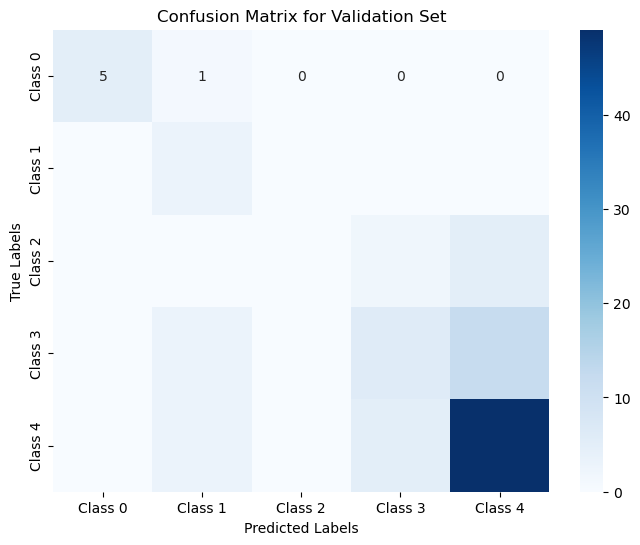

Confusion Matrix for Test:


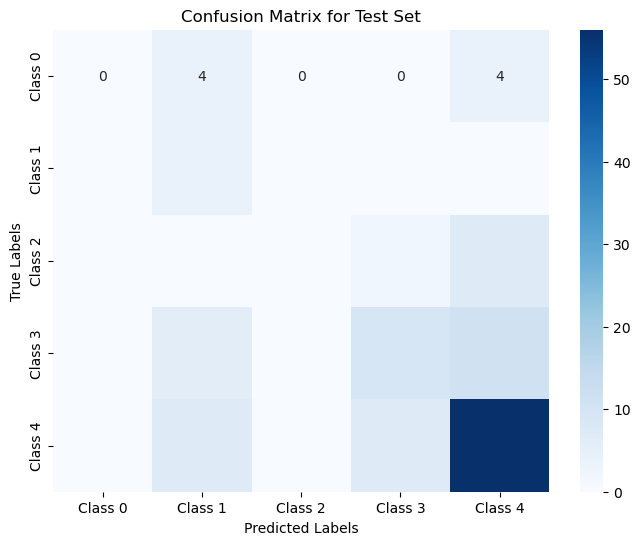

In [30]:
# Predictions for validation and test sets
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

# Convert predictions and true labels to class indices
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report for Validation
print("Classification Report (Validation):")
print(classification_report(y_val_classes, y_val_pred_classes))

# Confusion Matrix for Validation
cm_val = confusion_matrix(y_val_classes, y_val_pred_classes)

# Classification Report for Test
print("Classification Report (Test):")
print(classification_report(y_test_classes, y_test_pred_classes))

# Confusion Matrix for Test
cm_test = confusion_matrix(y_test_classes, y_test_pred_classes)

# Plot Confusion Matrix for Validation
print("Confusion Matrix for Validation:")
plot_confusion_matrix(cm_val, classes=[f"Class {i}" for i in range(len(np.unique(y_val_classes)))],
                      title="Confusion Matrix for Validation Set")

# Plot Confusion Matrix for Test
print("Confusion Matrix for Test:")
plot_confusion_matrix(cm_test, classes=[f"Class {i}" for i in range(len(np.unique(y_test_classes)))],
                      title="Confusion Matrix for Test Set")

In [ ]:
# FINAL MODEL ML
final_model = ExtraTreesClassifier(class_weight=class_weights_dict, random_state=42)

# Fit model
final_model.fit(x_train, y_train)

# Predict
y_val_pred = final_model.predict(x_val)
y_test_pred = final_model.predict(x_test)

# Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix for Validation
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)


# Plot confusion matrix for validation and test
print("Confusion Matrix (Validation):")
plot_confusion_matrix(cm_val, classes=np.unique(y_train), title='Validation Confusion Matrix')

print("Confusion Matrix (Test):")
plot_confusion_matrix(cm_test, classes=np.unique(y_train), title='Test Confusion Matrix')

ValueError: For multi-output, class_weight should be a list of dicts, or the string 'balanced'.